<a href="https://colab.research.google.com/github/ugursirvermez/PyTorch_Education/blob/main/06_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch Özel Veri Kümeleri (FoodVisionMini)

In [118]:
#KUTUPHANELER
import torch
from torch import nn
print(torch.__version__)
#Pytorch 1.10.0 üstü gereklidir!
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch import nn
from timeit import default_timer as timer # Zaman ayarları için var.
from tqdm.auto import tqdm #Eğitimi işlem barında göstermek için kullanacağız. Progess bar kütüphanesi
import requests #İnternet işlemleri için kütüphane
import random #rastgele Python kütüphanesi
from PIL import Image #Python Imaging Library -> kütüphanenin ne işe yaradığını isminden anlamışsınızdır :)
import os # Operation System kütüphanesi
import zipfile #Zip Dosyaları ile ilgili işlemleri yapar.
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Dict, List

#Cihazımızı tanıtalım.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

#The Food-101 Dataset Atıfı
#@inproceedings{bossard14,
#  title = {Food-101 -- Mining Discriminative Components with Random Forests},
#  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
#  booktitle = {European Conference on Computer Vision},
#  year = {2014}
#}

2.4.1+cu121
cpu


## DataSet İndirme

In [119]:
#Özel veri setimizi indirip oluşturalım.
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#Eğer dosya yoksa indir.
if image_path.is_dir():
	print(f"{image_path} dosyası zaten var...")
else:
	print(f"{image_path} dosyası oluşturuluyor...")
	image_path.mkdir(parents=True, exist_ok=True)

#Dosyaları indir
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
	request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
	print("Zip dosyası indiriliyor...")
	f.write(request.content)

#İnen dosyaları zip'ten çıkaralım.
with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
	print("Zip'ten dosyalar çıkarılıyor...")
	zip_ref.extractall(image_path)

print("VERİ SETİ OLUŞTURULDU!")

data/pizza_steak_sushi dosyası zaten var...
Zip dosyası indiriliyor...
Zip'ten dosyalar çıkarılıyor...
VERİ SETİ OLUŞTURULDU!


##Özel Veri Setini Tensörlere Dönüştürme

In [120]:
#Verileri Hazırlama Aşaması
def walk_through_dir(dir_path):
	#Tensöre dönüştürmeden önce dosyaya ulaşmamız gerekiyor.
	#Bunun için klasör yolu, klasör adı, dosya adını bulmalıyız.
	for dirpath, dirnames, filenames in os.walk(dir_path):
		print(f"{len(dirnames)} adet dosya ve {len(filenames)} resimler; belirtilen {dirpath} yolunda")

walk_through_dir(image_path) #yukarıda image_path'i tanıtmıştık.

2 adet dosya ve 0 resimler; belirtilen data/pizza_steak_sushi yolunda
3 adet dosya ve 0 resimler; belirtilen data/pizza_steak_sushi/train yolunda
0 adet dosya ve 75 resimler; belirtilen data/pizza_steak_sushi/train/steak yolunda
0 adet dosya ve 72 resimler; belirtilen data/pizza_steak_sushi/train/sushi yolunda
0 adet dosya ve 78 resimler; belirtilen data/pizza_steak_sushi/train/pizza yolunda
3 adet dosya ve 0 resimler; belirtilen data/pizza_steak_sushi/test yolunda
0 adet dosya ve 19 resimler; belirtilen data/pizza_steak_sushi/test/steak yolunda
0 adet dosya ve 31 resimler; belirtilen data/pizza_steak_sushi/test/sushi yolunda
0 adet dosya ve 25 resimler; belirtilen data/pizza_steak_sushi/test/pizza yolunda


data/pizza_steak_sushi/train/steak/234626.jpg yolundaki ve steak türündeki dosya şu şekildedir: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512 at 0x7CC1EA5E87F0>


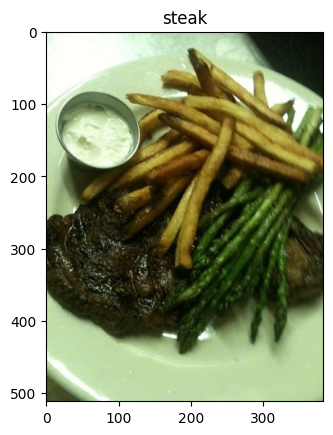

In [121]:
#Train ve Test klasörlerini Ayarlama
#klasörlerin yolunu belirtelim.
train_dir = image_path / "train"
test_dir = image_path / "test"

#Verilerimizi görsel olarak görelim. Nelere sahibiz?
random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg")) #bütün birbirleriyle ilişkili dosyaları yaz.
#print(image_path_list) #Bütün dosya yollarını yazdırıyoruz.

#Rastgele resim yolu seçelim.
random_image_path = random.choice(image_path_list)

#Rastgele resmi rastgele dosya yoluyla görelim.
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"{random_image_path} yolundaki ve {image_class} türündeki dosya şu şekildedir: {img}")
plt.imshow(img)
plt.title(image_class)
plt.show()

##Tensöre Dönüştürme Aşaması-1

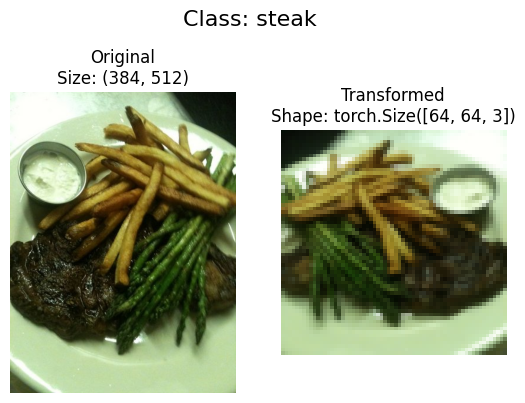

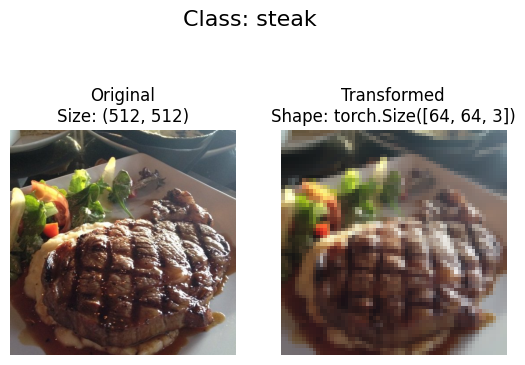

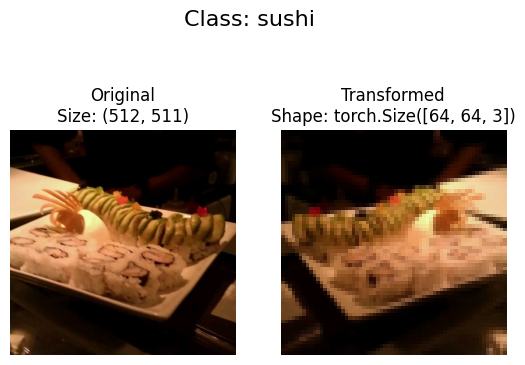

In [122]:
#Verileri Görelim.
#Reimleri array'e çevirelim.
img_as_array = np.asarray(img) #Veriler sayısallaşır ancak aradığımız tensör değildir!

#Dataset ve DataLoader ile verileri dönüştürüp kullanacağız.
#Veriyi torchvision.transforms sayesinde dönüştüreceğiz.
data_transform = transforms.Compose([
#Resimlerimizi 64x64'e dönüştüreceğiz.
transforms.Resize(size=(64,64)),
#resimleri yatay çevirelim.
transforms.RandomHorizontalFlip(p=0.5),
#Verimizi tensöre çevirelim. PIL Image veya numpy kabul eder.
transforms.ToTensor()])

#Dönüşen verilerimizi görelim.
def plot_transformed_images(image_paths, transform, n=3, seed=42):
	#Rastgele verilere bakalım.
	if seed:
		random.seed(seed)
	random_image_paths = random.sample(image_paths, k=n)
	#Resimlerin yollarını bulalım.
	for image_path in random_image_paths:
		with Image.open(image_path) as f:
			fig,ax = plt.subplots(nrows=1,ncols=2)
			ax[0].imshow(f)
			ax[0].set_title(f"Original\nSize: {f.size}")
			ax[0].axis(False)
			#Dönüşen ve görülen verilere bak. Tensörün boyutuna bakılmalı.
			transformed_image = transform(f).permute(1,2,0) #(Color,Height,Width) -> (Height,Width,Color)
			ax[1].imshow(transformed_image)
			ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
			ax[1].axis("off")
			fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

#Fonksiyonu Çalıştıralım.
plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3, seed=42)

##Veri Doldurma Seçenek-1 (2.Seçenek Notion'da)

In [123]:
#torchvision.datasets.ImageFolder kullanarak verileri doldurabiliriz.
from torchvision import datasets
#root -> Hangi dosyaya?, transform -> kim dönüşecek?, target_transform -> kime dönüşecek?
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
#Aynı yöntem uygulanır.
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

#Sınıf isimlerini listeleyelim.
class_names = train_data.classes
#Sözlük(Dict) olarak yazalım.
class_dict = train_data.class_to_idx
#Shape, Type, Label uyuşmazlığı için veriyi durmadan kontrol etmeliyiz.

##Dataset -> DataLoader

In [124]:
#DataLoader datasetleri kullanmamızı sağlayan bir araçtır.
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE,
															num_workers=os.cpu_count(),shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE,
															num_workers=os.cpu_count(),shuffle=False)

#DataLoader yazdıralım.
img, label = next(iter(test_dataloader))
print(f"Image Shape: {img.shape} (BS,C,H,W)")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([32, 3, 64, 64]) (BS,C,H,W)
Label Shape: torch.Size([32])


##Veri Doldurma-2

In [125]:
#Veri Doldurma-2
#os.scandir() -> hedef dosyayı dönüştürmek için dosyayı tarayacak
target_directory = train_dir
#hedef yoldaki sınıf isimlerini alalım.
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
print(class_names_found)
#Sınıf bulma fonksiyonu yazalım.
def find_classes(directory: str) -> Tuple[list[str], Dict[str, int]]:
	#scandir ile tarama yapalım.
	classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
	if not classes:
		raise FileNotFoundError(f"Herhangi bir sınıf bulunamadı...{directory}")
	class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
	return classes, class_to_idx

find_classes(target_directory)

['pizza', 'steak', 'sushi']


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#Sıfırdan Özel Veri Seti Yazma